In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from ott.core import sinkhorn
from ott.geometry import pointcloud
import os
import anndata
import wot
import scanpy as sc
import pandas as pd

In [2]:
data_path = "/home/icb/dominik.klein/data/wot"


VAR_GENE_DS_PATH = os.path.join(data_path, 'ExprMatrix.var.genes.h5ad')
CELL_DAYS_PATH = os.path.join(data_path, 'cell_days.txt')
SERUM_CELL_IDS_PATH = os.path.join(data_path, 'serum_cell_ids.txt')
CELL_GROWTH_PATH = os.path.join(data_path, 'growth_gs_init.txt')
FULL_DS_PATH = os.path.join(data_path, 'ExprMatrix.h5ad')
CELL_DAYS_PATH = os.path.join(data_path, 'cell_days.txt')
VAR_DS_PATH = os.path.join(data_path, 'ExprMatrix.var.genes.h5ad')
TMAP_PATH = os.path.join(data_path, 'serum')
CELL_SETS_PATH = os.path.join(data_path, 'major_cell_sets.gmt')
COORDS_PATH = os.path.join(data_path, 'fle_coords.txt')

In [3]:
adata = wot.io.read_dataset(VAR_GENE_DS_PATH, obs=[CELL_DAYS_PATH, CELL_GROWTH_PATH], obs_filter=SERUM_CELL_IDS_PATH)

In [4]:
sc.pp.pca(adata, n_comps=30)

In [5]:
DAYS = list(adata.obs.day.unique())
DAYS.pop(-1) # remove nan

nan

In [6]:
PCA30_SERUM_DAY = {}
for d in DAYS:
    PCA30_SERUM_DAY[d] = adata[adata.obs.day == d].obsm["X_pca"]

In [7]:
CELL_GROWTH_RATE = {}
for d in DAYS:
    CELL_GROWTH_RATE[d] = adata[adata.obs.day == d].obs["cell_growth_rate"].values

In [8]:
epsilon = 5

dict_results = {}
for i, day in enumerate(DAYS):
    if day == 18.:
        continue
    print('\r' + f'Executing Sinkhorn between the days {day} and {DAYS[i+1]} / 18', end='')
    # Computes the marginals
    delta_days = DAYS[i+1] - day
    n = PCA30_SERUM_DAY[DAYS[i+1]].shape[0]
    # The original data has been transformed with PCA as described in [1]
    a = np.power(CELL_GROWTH_RATE[day], delta_days) / np.mean(
      np.power(CELL_GROWTH_RATE[day], delta_days)) / n
    b = np.ones(n) / n

    # Applies optimal transport
    geom = pointcloud.PointCloud(
      PCA30_SERUM_DAY[day], PCA30_SERUM_DAY[DAYS[i+1]], epsilon=epsilon)
    out = sinkhorn.sinkhorn(geom, a, b, tau_a=1/(1+epsilon), tau_b=1)

    # Saves the geometry and the potentials to calculate the ancestors at a later time
    dict_results[day] = [geom, out.f, out.g]

Executing Sinkhorn between the days 17.5 and 18.0 / 18

In [10]:
CELL_SETS_PATH = os.path.join(data_path, 'major_cell_sets.gmt')
cell_sets = wot.io.read_sets(CELL_SETS_PATH, as_dict=True)
cell_to_type = {v[i]: k for k, v in cell_sets.items() for i in range(len(v))}
df_cell_type = pd.DataFrame(cell_to_type.items(), columns=["0", "cell_type"]).set_index("0")
adata.obs = pd.merge(adata.obs, df_cell_type, how="left", left_index=True, right_index=True)
adata

AnnData object with n_obs × n_vars = 175472 × 1479
    obs: 'day', 'cell_growth_rate', 'cell_type'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [11]:
adata.obs.cell_type.value_counts()

Stromal        25282
IPS            12015
Epithelial     10504
Trophoblast     6361
Neural          4317
Name: cell_type, dtype: int64

In [12]:
adata_18 = adata[adata.obs.day==18.0].obs.cell_type == "IPS"


CELL_DISTRIBUTION_IPSC_DAY18 = adata_18/np.sum(adata_18)

In [13]:
cell_distribution_ipsc = {}
reverse_days = DAYS[::-1]
for i, day in enumerate(reverse_days):
    print('\r' + f'Infering ancestor cells at day {day}', end='')
    if day == 0.:
        continue
    if day == 18.:
        cell_distribution_ipsc[day] = CELL_DISTRIBUTION_IPSC_DAY18
    # Calculates cells' ancestors
    geom = dict_results[reverse_days[i+1]][0]
    f = dict_results[reverse_days[i+1]][1]
    g = dict_results[reverse_days[i+1]][2]
    cell_distribution = geom.apply_transport_from_potentials(
      f, g, cell_distribution_ipsc[day], axis=1)
    cell_distribution_ipsc[reverse_days[i+1]] = cell_distribution / np.sum(
      cell_distribution)

Infering ancestor cells at day 18.0

/mnt/home/icb/dominik.klein/git_repos/ott/ott/ott/geometry/geometry.py:364: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return self._apply_transport_from_potentials(f, g, vec[jnp.newaxis, :],


Infering ancestor cells at day 0.05

In [14]:
COORD_DF = pd.read_csv(COORDS_PATH, sep='\t', index_col=0)

In [17]:
IDS_CELLS = {}
for d in DAYS:
    IDS_CELLS[d] = adata[adata.obs.day==d].obs.index

In [18]:
nbins = 500
xrange = COORD_DF['x'].min(), COORD_DF['x'].max()
yrange = COORD_DF['y'].min(), COORD_DF['y'].max()
COORD_DF['x'] = np.floor(
    np.interp(COORD_DF['x'], [xrange[0], xrange[1]], [0, nbins - 1])).astype(int)
COORD_DF['y'] = np.floor(
    np.interp(COORD_DF['y'], [yrange[0], yrange[1]], [0, nbins - 1])).astype(int)

In [19]:
coord_ancestors_ipsc = dict()
for day in DAYS:
    cell_ids = np.array(IDS_CELLS[day])
    coord_ancestors_ipsc[day] = COORD_DF[COORD_DF.index.isin(
        cell_ids)][['x', 'y']].values

In [21]:
alpha_bins = [1, 0.5, 0.]
binned_cell_distribution_ipsc = {}
for day in DAYS:
    tmp = np.array(cell_distribution_ipsc[day]).copy()
    tmp[tmp >= 1e-2] = alpha_bins[0]
    tmp[np.logical_and(1e-2 > tmp, tmp >= 5e-4)] = alpha_bins[1]
    tmp[5e-4 > tmp] = alpha_bins[2]
    binned_cell_distribution_ipsc[day] = tmp


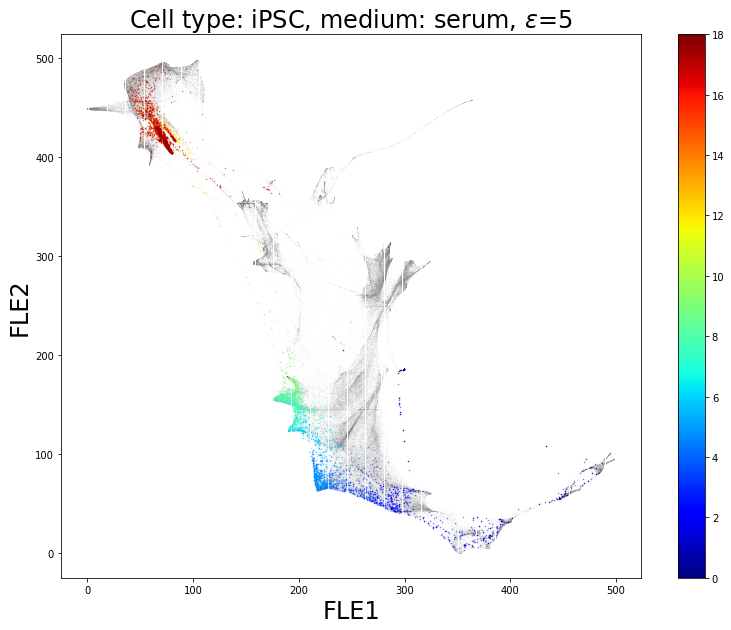

In [22]:
cm = plt.get_cmap('jet')
cNorm  = mpl.colors.Normalize(vmin=0, vmax=len(DAYS))
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cm)

fig = plt.figure(figsize=(13, 10))
plt.title(f'Cell type: iPSC, medium: serum, $\epsilon$={epsilon}', fontsize=24)
plt.plot(COORD_DF['x'], COORD_DF['y'], marker='.', color='grey', ls='',
         markersize=0.3, alpha=0.07)
for i, day in enumerate(DAYS):
  colorVal = scalarMap.to_rgba(i)
  for b in alpha_bins:
    ind_alpha = np.where(binned_cell_distribution_ipsc[day] == b)[0]
    colorVal = np.array(colorVal)
    colorVal[3] = b
    plt.plot(coord_ancestors_ipsc[day][ind_alpha, 0],
             coord_ancestors_ipsc[day][ind_alpha, 1],
           marker='.', color=colorVal, ls='', markersize=1)
plt.xlabel('FLE1', fontsize=24)
plt.ylabel('FLE2', fontsize=24)
ax, _ = mpl.colorbar.make_axes(plt.gca(), shrink=1)
cbar = mpl.colorbar.ColorbarBase(ax, cmap=cm,
                       norm=mpl.colors.Normalize(vmin=0, vmax=18))
plt.show()

In [25]:
dict_results[0.0][0].cost_matrix.shape

(4556, 3449)

In [24]:
dict_results[0.0][0].cost_matrix

DeviceArray([[ 337.0481  ,  529.2246  ,  417.37842 , ...,  635.1209  ,
               239.82297 , 1003.31793 ],
             [ 212.64417 ,  355.81116 ,  357.5609  , ...,  529.0287  ,
                86.66943 ,  782.2418  ],
             [ 234.07031 ,  335.38284 ,  394.59137 , ...,  477.79886 ,
               193.402   ,  653.3356  ],
             ...,
             [ 306.23605 ,  427.0245  ,  419.05823 , ...,  718.69714 ,
               122.893555,  752.4356  ],
             [ 362.16663 ,  337.4965  ,  397.11365 , ...,  561.8597  ,
               186.98022 ,  973.9687  ],
             [ 291.38916 ,  424.9289  ,  377.57825 , ...,  728.0144  ,
               183.39648 ,  982.7419  ]], dtype=float32)